# 🌀 Diffusion Models

Diffusion models can be considered hierarchicals VAE without a learned encoder

## 🎯 Motivation: Generating High-Quality Images

Diffusion models are a powerful class of **generative models** that can produce stunningly realistic images. They do this by learning how to **gradually denoise** random noise into data — in contrast to VAEs or GANs which directly output samples in one step.

---

## 🌫️ Forward Process: Diffusion

We define a **forward (noising) process** $q(x_{1:T} \mid x_0)$ that gradually adds Gaussian noise to a data sample $x_0$ over $T$ discrete time steps.

This process forms a **Markov chain** — each noisy sample $x_t$ depends **only on** the previous step $x_{t-1}$:

$$
q(x_t \mid x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} \, x_{t-1}, \beta_t \mathbf{I})
$$

Where:

- $x_0$ is the original data sample
- $\beta_1, \dots, \beta_T$ is a fixed noise schedule
- As $t \to T$, $x_t$ becomes increasingly noisy and approaches pure Gaussian noise

> **About $\beta_t$**: Each $\beta_t$ controls how much **variance** is added at step $t$. Equivalently, we can define $\alpha_t = 1 - \beta_t$. Then, for each step:
> $$
> x_t = \sqrt{\alpha_t}\,x_{t-1} \;+\; \sqrt{1 - \alpha_t}\,\epsilon_t,
> $$
> where $\epsilon_t \sim \mathcal{N}(0,\mathbf{I})$. This $\beta$-based schedule allows direct control of the **amount of noise** injected each step.

The full joint distribution over the diffusion trajectory is:

$$
q(x_{1:T} \mid x_0) = \prod_{t=1}^T q(x_t \mid x_{t-1})
$$

Because this is a **Markov process**, we don’t need to condition on the entire history — just the immediate predecessor.

---

## 🏎 Beta Schedules: Linear vs. Cosine

### Linear Beta Scheduling

- **Linear**: We simply pick $\beta_t$ to increase linearly from $\beta_{\text{start}}$ to $\beta_{\text{end}}$.  
- For example, $$\beta_t = \beta_{\text{start}} + t \cdot \frac{(\beta_{\text{end}} - \beta_{\text{start}})}{T-1}.$$
- **Pros**: Simple and easy to tune.
- **Cons**: Often adds too little noise in early steps and too much in later steps, sometimes causing less stable training or splotchy samples.

### Cosine Beta Scheduling

- **Cosine**: Proposed in *Improved DDPM* (Nichol & Dhariwal, 2021).
- Instead of defining $\beta_t$ directly, we define the cumulative product $\bar{\alpha}_t$ via a **cosine** function:
  $$
  \bar{\alpha}_t \;=\; \frac{\cos^2\!\bigl(\tfrac{(t/T + s)}{1 + s}\,\tfrac{\pi}{2}\bigr)}{\cos^2\!\bigl(\tfrac{s}{1 + s}\,\tfrac{\pi}{2}\bigr)},
  $$
  then recover $\beta_t$ from $\beta_t = 1 - \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}.$
- **Pros**: Smoother schedule; preserves more signal in early steps; often yields better sample quality.
- **Cons**: Slightly more complex to implement, though the code is still straightforward.

---

## 🔁 Reverse Process: Generative Modeling

To generate data, we define a **reverse-time Markov chain**:

$$
p_\theta(x_{0:T}) = p(x_T) \prod_{t=1}^T p_\theta(x_{t-1} \mid x_t)
$$

Here:

- $p(x_T) = \mathcal{N}(0, \mathbf{I})$ is the starting point — pure Gaussian noise
- $p_\theta(x_{t-1} \mid x_t)$ is a learnable Gaussian distribution, parameterized by a neural network

Just like the forward process, this reverse chain is **Markovian**. Each step only depends on the current state $x_t$, not the entire history

This Markov structure simplifies the generative modeling process: we only need to learn how to take one step back in time, many times in a row.

Ideally, the learned reverse process $p_\theta(x_{t-1} \mid x_t)$ should match the true reverse conditionals $q(x_{t-1} \mid x_t, x_0)$ derived from the forward process.

---

## 📉 Variational Inference: ELBO Objective

Our ultimate goal is to model the **data distribution** $p_{\text{data}}(x_0)$ using a parameterized model $p_\theta(x_0)$. Ideally, we want to maximize:

$$
\log p_\theta(x_0)
$$

However, in a **latent variable model** like diffusion (or VAEs), $x_0$ is generated via **intermediate latent variables** — in this case, the noised versions $x_1, x_2, ..., x_T$.

So the marginal likelihood becomes:

$$
\log p_\theta(x_0) = \log \int p_\theta(x_0, x_1, ..., x_T) \, dx_{1:T}
= \log \int p_\theta(x_{0:T}) \, dx_{1:T}
$$

This integral is **intractable** because:

- $p_\theta(x_{t-1} \mid x_t)$ is parameterized by a neural network
- The latent space is high-dimensional (a trajectory over $T$ steps)

---

### 💡 Variational Trick: Importance Sampling

To deal with this, we apply **importance sampling**: introduce a known, tractable distribution $q(x_{1:T} \mid x_0)$ (the **forward diffusion process**) and rewrite the integral:

$$
\log p_\theta(x_0)
= \log \int \frac{q(x_{1:T} \mid x_0)}{q(x_{1:T} \mid x_0)} \, p_\theta(x_{0:T}) \, dx_{1:T}
= \log \mathbb{E}_{q(x_{1:T} \mid x_0)} \left[ \frac{p_\theta(x_{0:T})}{q(x_{1:T} \mid x_0)} \right]
$$

This is **exact** — we haven't approximated anything yet.

---

### ✅ Now Comes the Inequality: Jensen’s Inequality

The log of an expectation is **not equal to** the expectation of a log. In fact, by **Jensen’s inequality**, we have:

$$
\log \mathbb{E}_{q} \left[ f(x) \right] \geq \mathbb{E}_{q} \left[ \log f(x) \right]
$$

So applying this to our case:

$$
\log p_\theta(x_0)
= \log \mathbb{E}_{q(x_{1:T} \mid x_0)} \left[ \frac{p_\theta(x_{0:T})}{q(x_{1:T} \mid x_0)} \right]
\geq \mathbb{E}_{q(x_{1:T} \mid x_0)} \left[ \log \frac{p_\theta(x_{0:T})}{q(x_{1:T} \mid x_0)} \right]
$$

This **lower bound** is called the **Evidence Lower Bound (ELBO)**:

$$
\mathcal{L}_{\text{ELBO}} =
\mathbb{E}_{q(x_{1:T} \mid x_0)} \left[
\log p_\theta(x_{0:T}) - \log q(x_{1:T} \mid x_0)
\right]
$$

---

### 📌 Intuition

- We're approximating the true (intractable) marginal likelihood with a **lower bound** that we can **actually compute and optimize**.
- The closer $q(x_{1:T} \mid x_0)$ is to the true posterior $p_\theta(x_{1:T} \mid x_0)$, the **tighter** the bound.
- In VAEs, $q$ is learned. In diffusion, it’s **fixed** and designed — but still works because we structure it well (Gaussian forward steps).

---

## 🔁 Modeling the Joint Distributions

Let’s expand both terms:

### 🔹 Reverse (Generative) Process:

We define the joint generative distribution as:

$$
p_\theta(x_{0:T}) = p(x_T) \prod_{t=1}^T p_\theta(x_{t-1} \mid x_t)
$$

Where:

- $p(x_T)$ is the standard Gaussian prior
- $p_\theta(x_{t-1} \mid x_t)$ is modeled as a Gaussian parameterized by a neural net

### 🔹 Forward (Variational) Process:

The forward process (used for inference) is fixed and Markovian:

$$
q(x_{1:T} \mid x_0) = \prod_{t=1}^T q(x_t \mid x_{t-1})
$$

---

## 🧮 ELBO Breakdown

Plugging the expressions in:

$$
\mathcal{L}_{\text{ELBO}} =
\mathbb{E}_{q(x_{1:T} \mid x_0)} \left[
\log p(x_T) + \sum_{t=1}^T \log p_\theta(x_{t-1} \mid x_t)
- \sum_{t=1}^T \log q(x_t \mid x_{t-1})
\right]
$$

Group terms by time step:

$$
\mathcal{L}_{\text{ELBO}} =
\mathbb{E}_{q(x_{1:T} \mid x_0)} \left[
\log p(x_T) - \log q(x_1 \mid x_0)
+ \log p_\theta(x_0 \mid x_1)
+ \sum_{t=2}^T \left(
\log p_\theta(x_{t-1} \mid x_t) - \log q(x_t \mid x_{t-1})
\right)
\right]
$$

Rewriting in terms of KLs (using the closed-form for KL between Gaussians):

---

## 🔍 Interpretation of the ELBO Terms

### 🔹 1. Prior Matching at $t = T$

Encourages the terminal distribution $x_T$ to match the prior:

$$
D_{\text{KL}}(q(x_T \mid x_0) \, \| \, p(x_T))
$$

---

### 🔹 2. Reverse KL Terms for $t = 2, \dots, T$

Match the learned reverse distribution to the true posterior:

$$
\mathbb{E}_{q(x_{t}, x_{t-1} \mid x_0)} \left[
D_{\text{KL}} \left( q(x_{t-1} \mid x_t, x_0) \,\|\, p_\theta(x_{t-1} \mid x_t) \right)
\right]
$$

These KLs can be computed in closed form because all distributions are Gaussian.

---

### 🔹 3. Reconstruction Term at $t=1$

At the final step, the model attempts to reconstruct $x_0$ from the slightly noised $x_1$:

$$
- \mathbb{E}_{q(x_1 \mid x_0)} \left[ \log p_\theta(x_0 \mid x_1) \right]
$$

This is analogous to the VAE reconstruction loss.

---

## ✅ Final Variational Loss (Full DDPM Objective)

Bringing it all together:

$$
\mathcal{L}_{\text{VLB}} =
\underbrace{D_{\text{KL}}(q(x_T \mid x_0) \,\|\, p(x_T))}_{\text{Prior term}}
+ \sum_{t=2}^T
\underbrace{D_{\text{KL}}(q(x_{t-1} \mid x_t, x_0) \,\|\, p_\theta(x_{t-1} \mid x_t))}_{\text{Reverse KLs}}
- \underbrace{\mathbb{E}_{q(x_1 \mid x_0)} \left[ \log p_\theta(x_0 \mid x_1) \right]}_{\text{Reconstruction}}
$$

This is the **original training objective** introduced in _DDPM (Ho et al., 2020)_ — and is a true variational lower bound on $\log p_\theta(x_0)$.

---

## ✂️ Simplifying the ELBO: From Variational Bound to Noise Prediction

In practice, diffusion models are trained using a **much simpler objective** than the full ELBO derived earlier. This section explains why that's valid and how it works.

---

### 🔁 Recall: The Full ELBO

The full ELBO from the DDPM objective is:

$$
\mathcal{L}_{\text{VLB}} =
D_{\text{KL}}(q(x_T \mid x_0) \,\|\, p(x_T))
+ \sum_{t=2}^T D_{\text{KL}}(q(x_{t-1} \mid x_t, x_0) \,\|\, p_\theta(x_{t-1} \mid x_t))
- \mathbb{E}_{q(x_1 \mid x_0)} \left[ \log p_\theta(x_0 \mid x_1) \right]
$$

The **KL terms** at each timestep measure how well the learned reverse distribution $p_\theta(x_{t-1} \mid x_t)$ matches the true reverse posterior $q(x_{t-1} \mid x_t, x_0)$.

---

### 🧠 Insight: KL Between Gaussians Has a Closed Form

All distributions involved are Gaussian, so we can compute the KL divergence analytically.

Specifically, for each $t \geq 1$, the true posterior is:

$$
q(x_{t-1} \mid x_t, x_0) = \mathcal{N}\left(x_{t-1}; \mu_q(x_t, x_0), \Sigma_q(t)\right)
$$

We approximate it with:

$$
p_\theta(x_{t-1} \mid x_t) = \mathcal{N}\left(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(t)\right)
$$

To minimize the KL divergence between these two Gaussians, we only need to match their **means** (since variances are fixed or learned separately). So:

> Training reduces to minimizing the squared error between the true posterior mean $\mu_q(x_t, x_0)$ and the predicted mean $\mu_\theta(x_t, t)$.

---

### 🧩 Expressing the True Mean $\mu_q$ in Terms of Noise $\epsilon$

From the **forward process**, we know that the noisy image at timestep $t$ can be written as a linear combination of the original image $x_0$ and Gaussian noise $\epsilon$:

$$
x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon,
\quad \text{with } \epsilon \sim \mathcal{N}(0, \mathbf{I})
$$

This equation allows us to **sample $x_t$ from $x_0$**.

But what if we want to **recover $x_0$ from $x_t$**?

Assuming we *know* $\epsilon$, we can rearrange the equation:

$$
x_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \left( x_t - \sqrt{1 - \bar{\alpha}_t} \, \epsilon \right)
$$

This means:  
> If we have $x_t$ and can estimate $\epsilon$, we can **reconstruct** $x_0$.

Now recall the **true reverse posterior**:

$$
q(x_{t-1} \mid x_t, x_0) = \mathcal{N}(x_{t-1}; \mu_q(x_t, x_0), \Sigma_q(t))
$$

We won't derive the exact form of $\mu_q$, but it turns out that it is a **linear combination of $x_t$ and $x_0$**:

$$
\mu_q(x_t, x_0) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \, \epsilon \right)
$$

> So again, we can write the **true mean of the reverse process** in terms of $(x_t, \epsilon)$.

If our model learns to **predict the noise $\epsilon$** from a given $(x_t, t)$, then we can **plug it in to compute $\mu_q$**, and thus define a Gaussian distribution from which we can sample $x_{t-1}$.

---

### 🧪 Final Simplified Objective: L2 Loss on Noise

Given that:

- We want to train a model $\epsilon_\theta(x_t, t)$ to predict the noise $\epsilon$ that was added to create $x_t$,
- And that $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon$,

We define the training loss as the **L2 distance** between the true noise $\epsilon$ and the predicted noise:

$$
\mathcal{L}_{\text{simple}}(x_0) =
\mathbb{E}_{t \sim \text{Uniform}(1, T),\, \epsilon \sim \mathcal{N}(0, I)} \left[
\left\| \epsilon - \epsilon_\theta(x_t, t) \right\|^2
\right]
$$

To compute this during training:

1. Sample $x_0$ from the dataset.
2. Sample a timestep $t$ uniformly at random.
3. Sample noise $\epsilon \sim \mathcal{N}(0, I)$.
4. Compute $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$.
5. Use the model to predict noise: $\hat{\epsilon} = \epsilon_\theta(x_t, t)$.
6. Minimize the squared error: $\|\epsilon - \hat{\epsilon}\|^2$.

This is equivalent to minimizing the KL divergence between $q(x_{t-1} \mid x_t, x_0)$ and $p_\theta(x_{t-1} \mid x_t)$.

---

### 🎨 How Noise Prediction is Used to Generate Images

Once the model is trained to predict noise, we can **generate images** starting from random noise. Here's how:

#### 1. Start from Gaussian noise:
$$
x_T \sim \mathcal{N}(0, \mathbf{I})
$$

#### 2. Run the reverse process:
For $t = T, T-1, \dots, 1$:

1. Predict noise: $\hat{\epsilon}_\theta = \epsilon_\theta(x_t, t)$
2. Estimate $x_0$:
   $$
   \hat{x}_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \left( x_t - \sqrt{1 - \bar{\alpha}_t} \, \hat{\epsilon}_\theta \right)
   $$
3. Compute the mean of $p_\theta(x_{t-1} \mid x_t)$ using $\hat{x}_0$ (or directly use a pre-derived formula).
4. Sample:
   $$
   x_{t-1} \sim \mathcal{N}(\mu_\theta(x_t, \hat{\epsilon}_\theta), \Sigma_\theta(t))
   $$

Repeat until $x_0$, the final sample, is reached.

This $x_0$ is your **generated image**!

---

## ✅ Summary

- We use the forward process to generate training pairs $(x_t, \epsilon)$.
- The model learns to **predict $\epsilon$** from $(x_t, t)$.
- Once trained, we can **start from noise** and **denoise step-by-step** using the predicted $\epsilon$.
- The process is grounded in a **true probabilistic model** and the noise prediction is equivalent (up to constants) to maximizing the variational lower bound.

## References

- [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)
- [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2102.09672)

# 🚀 Extended Explanation of the Code: DDPM Implementation Details

Below is a **supplement** to the earlier diffusion discussion. It explains the **key components** in the provided Denoising Diffusion Probabilistic Model (DDPM) code, such as the **UNet with Time Conditioning**, the **`MNISTDiffusion` class encapsulating the DDPM logic**, and **training specifics**. U-Net is used in diffusion models because its skip connections allow the model to preserve fine-grained spatial details from the input noisy image while also capturing global context through the encoder-decoder structure, which is essential for accurately predicting the noise pattern that needs to be removed at each denoising step.

---

## 1. **UNet with Time Conditioning**

The core of our diffusion model is a U-Net that predicts the noise $\epsilon$ added to an image $x_0$ at a given timestep $t$. This U-Net uses standard convolutional blocks for clarity and simplicity. The critical addition for multi-step diffusion is **time conditioning**.

1.  **U-Net Architecture Recap**:
    *   It has an **encoder** (downsampling path), a **bottleneck**, a **decoder** (upsampling path), and **skip connections**.
    *   Simple blocks like `ConvBlock`, `ResBlock`, `DownBlock`, and `UpBlock` are used for straightforward implementation.

2.  **TimeMLP: Injecting Timestep Information**:
    *   In a DDPM, the model must know the current noise level (timestep $t$) to effectively denoise $x_t$.
    *   The timestep $t$ is first converted into a fixed-size **time embedding vector** $\mathbf{e}_t$ (using `nn.Embedding`).
    *   This embedding $\mathbf{e}_t$ is then processed by a `TimeMLP` (a small multi-layer perceptron) to produce a conditioning vector $\mathbf{b}_t$ whose dimensionality matches the number of channels in the U-Net's feature maps at various stages.
        $$
        t \;\xrightarrow[]{\text{Embedding}}\; \mathbf{e}_t \in \mathbb{R}^{d_{emb}} \quad \xrightarrow[]{\text{TimeMLP}}\; \mathbf{b}_t \in \mathbb{R}^{\text{channels}}
        $$
    *   This conditioning vector $\mathbf{b}_t$ is then **added element-wise** to the feature maps $\mathbf{x}$ within the U-Net blocks (e.g., after a convolutional layer in an `EncoderBlock` or `DecoderBlock`):
        $$
        \mathbf{x} \;\leftarrow\; \mathbf{x} + \mathbf{b}_t
        $$
    *   This is a form of **FiLM (Feature-wise Linear Modulation)**, specifically an additive modulation. It allows the network to adapt its behavior based on $t$.

3.  **`EncoderBlock` / `DecoderBlock` with Time Injection**:
    *   The `EncoderBlock` and `DecoderBlock` modules in the `Unet` class are modified to accept the time embedding and use the `TimeMLP`.
    *   Example from `EncoderBlock`:
        ```python
        # Inside EncoderBlock's forward method
        for res_block in self.res_blocks:
            x = res_block(x)
        
        # Time conditioning
        if t is not None:
            x = self.time_mlp(x, t)  # inject time
        
        x_skip = x
        x = self.downsample(x)  # downsample
        ```
    *   This ensures that at multiple points in the network, the processing is conditioned on the current noise level $t$.

---

## 2. **`MNISTDiffusion` Class: The Full DDPM Pipeline**

The `MNISTDiffusion` class orchestrates the entire DDPM.

1.  **Cosine Beta Schedule (`_cosine_variance_schedule`)**:
    *   Defines the noise variances $\beta_t$ for each timestep $t=1, \dots, T$.
    *   From $\beta_t$, it precomputes $\alpha_t = 1 - \beta_t$, and the cumulative products $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$. These are essential for both the forward (noising) and reverse (sampling) processes.
    *   Buffers like `sqrt_alphas_cumprod` and `sqrt_one_minus_alphas_cumprod` are registered for efficient use in `q_sample`.

2.  **Forward Process for Training (`forward` and `q_sample`)**:
    *   The `forward` method of `MNISTDiffusion` is called during training.
    *   It samples a random timestep $t$ for each image in a batch.
    *   It then calls `q_sample(x0, t, noise)` to produce the noised image $x_t$:
        $\displaystyle x_t = \sqrt{\bar{\alpha}_t}\,x_0 + \sqrt{1-\bar{\alpha}_t}\,\text{noise}.$
    *   $x_t$ and $t$ are fed into the U-Net model (`self.model`) to get the predicted noise $\hat{\epsilon}$.
    *   The training loss is then computed as $\|\hat{\epsilon}-\epsilon\|^2$.

3.  **Reverse Process for Sampling (`sample`, `p_sample`, `p_sample_clipped`)**:
    *   The `sample` method generates new images.
    *   It starts with pure Gaussian noise $x_T \sim \mathcal{N}(0,I)$.
    *   It then iterates backwards from $t=T$ down to $t=1$, performing the DDPM reverse step at each $t$:
        1.  Predict noise $\hat{\epsilon} = \text{model}(x_t, t)$.
        2.  The `p_sample` or `p_sample_clipped` method then uses this $\hat{\epsilon}$ to compute the mean of $p_\theta(x_{t-1} \mid x_t)$ and samples $x_{t-1}$.
            *   `p_sample_clipped` first estimates $\hat{x}_0$ from $x_t$ and $\hat{\epsilon}$, clips $\hat{x}_0$ to the valid data range (e.g., $[-1,1]$), and then uses this clipped $\hat{x}_0$ to derive the mean for sampling $x_{t-1}$. This often improves sample quality.
        3.  If $t>1$, Gaussian noise (scaled by a scheduled variance $\sigma_t$) is added. If $t=1$ (final step), no noise is added to the mean.
    *   The final $x_0$ is then typically unnormalized (e.g., from $[-1,1]$ to $[0,1]$).

---

## 3. **Training Details**

*   **Data**: MNIST images are loaded and normalized to the range $[-1,1]$.
*   **Loss**: Mean Squared Error (MSE) between the true added noise $\epsilon$ and the U-Net's predicted noise $\hat{\epsilon}$.
    *   **Why MSE?**: As discussed in the theoretical sections, minimizing $\|\epsilon - \epsilon_\theta(x_t, t)\|^2$ is equivalent (up to weighting factors often ignored in simpler implementations) to optimizing the terms in the ELBO that involve matching the mean of the learned reverse distribution $p_\theta(x_{t-1}|x_t)$ to the mean of the true posterior $q(x_{t-1}|x_t, x_0)$.
*   **Optimization**: The Adam optimizer is used to update the U-Net's parameters.
*   **Logging**: Periodically, during training, the current loss is logged, and image samples are generated using the `sample` method to visually inspect progress.

---

## 4. **Putting It All Together (DDPM Context)**

1.  The code implements a **DDPM** for MNIST generation.
2.  Key components include:
    *   A **simple U-Net with standard convolutions** for noise prediction.
    *   **Time conditioning** via `nn.Embedding` and `TimeMLP` to inform the U-Net about the current noise level $t$.
    *   A **cosine beta schedule** for a smooth noising process.
    *   **Clipping** of the predicted $\hat{x}_0$ during sampling to maintain valid pixel values.
3.  **Training Loop**:
    *   For each batch, sample random timesteps $t$.
    *   Noise images to $x_t$.
    *   Train the U-Net to predict the added noise $\epsilon$ using an MSE loss.
4.  **Sampling Loop**:
    *   Start from $x_T \sim \mathcal{N}(0,I)$.
    *   Iteratively apply the learned reverse (denoising) step, using the U-Net's noise prediction at each $t$, until $x_0$ is obtained.

This setup provides a fully functional, straightforward DDPM that incorporates common improvements found in modern diffusion model implementations.

---

## 🎉 **Conclusion (DDPM Context)**

*   The implemented pipeline is a standard **DDPM** enhanced with typical improvements like a **cosine beta schedule** and a **time-conditioned U-Net**.
*   The underlying mathematical framework aligns with the original **DDPM** paper, with the noise prediction objective being a practical simplification of the full variational bound.
*   The combination of simple architectural choices and proven training strategies leads to successful training and good quality image generation on datasets like MNIST, demonstrating the core concepts without unnecessary complexity.

You now have a comprehensive overview of how the simple code components fit together to realize a Denoising Diffusion Probabilistic Model.

## References

- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
- [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)

In [ ]:
# Simplified Diffusion with Regular Convolutions

import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class ResBlock(nn.Module):
    """Simple residual block with regular convolutions"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = ConvBlock(channels, channels)
        self.conv2 = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
        )
        self.act = nn.SiLU()

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + residual
        return self.act(x)


class DownBlock(nn.Module):
    """Downsample block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvBlock(in_channels, out_channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)


class UpBlock(nn.Module):
    """Upsample block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.up(x)
        return self.conv(x)


class TimeMLP(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, out_dim),
        )
        self.act = nn.SiLU()

    def forward(self, x, t):
        t_emb = self.mlp(t).unsqueeze(-1).unsqueeze(-1)
        x = x + t_emb
        return self.act(x)


class EncoderBlock(nn.Module):
    """Encoder block with residual layers and downsampling"""
    def __init__(self, in_channels, out_channels, time_dim, num_res_blocks=2):
        super().__init__()
        
        # Residual blocks at current resolution
        self.res_blocks = nn.ModuleList([
            ResBlock(in_channels) for _ in range(num_res_blocks)
        ])
        
        # Time conditioning
        self.time_mlp = TimeMLP(time_dim, out_channels, in_channels)
        
        # Downsample
        self.downsample = DownBlock(in_channels, out_channels)

    def forward(self, x, t=None):
        # Apply residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)
        
        # Time conditioning
        if t is not None:
            x = self.time_mlp(x, t)
        
        # Save skip connection before downsampling
        x_skip = x
        
        # Downsample
        x = self.downsample(x)
        
        return x, x_skip


class DecoderBlock(nn.Module):
    """Decoder block with upsampling and residual layers"""
    def __init__(self, in_channels, out_channels, time_dim, num_res_blocks=2):
        super().__init__()
        
        # Upsample
        self.upsample = UpBlock(in_channels, out_channels)
        
        # Residual blocks after concatenation (out_channels + skip_channels)
        self.res_blocks = nn.ModuleList([
            ResBlock(out_channels * 2) for _ in range(num_res_blocks)
        ])
        
        # Time conditioning
        self.time_mlp = TimeMLP(time_dim, out_channels * 2, out_channels * 2)
        
        # Final conv to reduce channels
        self.final_conv = ConvBlock(out_channels * 2, out_channels)

    def forward(self, x, x_skip, t=None):
        # Upsample
        x = self.upsample(x)
        
        # Concatenate with skip connection
        x = torch.cat([x, x_skip], dim=1)
        
        # Apply residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)
        
        # Time conditioning
        if t is not None:
            x = self.time_mlp(x, t)
        
        # Final conv
        x = self.final_conv(x)
        
        return x


class Unet(nn.Module):
    """Simple UNet with regular convolutions"""
    def __init__(
        self,
        timesteps,
        time_embedding_dim,
        in_channels=1,
        out_channels=1,
        base_dim=64,
        dim_mults=[2, 4],
        num_res_blocks_encoder=2,
        num_res_blocks_decoder=2,
        num_res_blocks_mid=2,
    ):
        super().__init__()
        
        # Initial conv
        self.init_conv = ConvBlock(in_channels, base_dim)
        
        # Time embedding
        self.time_emb = nn.Embedding(timesteps, time_embedding_dim)

        # Build channel dimensions
        dims = [base_dim]
        for mult in dim_mults:
            dims.append(base_dim * mult)

        # Encoder blocks
        self.enc_blocks = nn.ModuleList()
        for i in range(len(dims) - 1):
            self.enc_blocks.append(
                EncoderBlock(
                    dims[i], dims[i + 1], 
                    time_embedding_dim, 
                    num_res_blocks_encoder
                )
            )

        # Middle block
        mid_dim = dims[-1]
        self.mid_blocks = nn.ModuleList([
            ResBlock(mid_dim) for _ in range(num_res_blocks_mid)
        ])

        # Decoder blocks
        self.dec_blocks = nn.ModuleList()
        for i in range(len(dims) - 1, 0, -1):
            self.dec_blocks.append(
                DecoderBlock(
                    dims[i], dims[i - 1], 
                    time_embedding_dim, 
                    num_res_blocks_decoder
                )
            )

        # Final conv
        self.final_conv = nn.Conv2d(base_dim, out_channels, 1)

    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_emb(t)

        # Initial conv
        x = self.init_conv(x)

        # Encoder path
        skips = []
        for enc_block in self.enc_blocks:
            x, x_skip = enc_block(x, t_emb)
            skips.append(x_skip)

        # Middle blocks
        for mid_block in self.mid_blocks:
            x = mid_block(x)

        # Decoder path
        skips.reverse()
        for dec_block, x_skip in zip(self.dec_blocks, skips):
            x = dec_block(x, x_skip, t_emb)

        # Final conv
        return self.final_conv(x)


##################################################
# 2) MNISTDiffusion with Cosine Beta Schedule
##################################################
class MNISTDiffusion(nn.Module):
    def __init__(
        self,
        image_size=28,
        in_channels=1,
        time_embedding_dim=256,
        timesteps=1000,
        base_dim=64,
        dim_mults=[2, 4],
        num_res_blocks_encoder=2,
        num_res_blocks_decoder=2,
        num_res_blocks_mid=2,
    ):
        super().__init__()
        self.timesteps = timesteps
        self.in_channels = in_channels
        self.image_size = image_size

        betas = self._cosine_variance_schedule(timesteps)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=-1)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod)
        )

        self.model = Unet(
            timesteps=timesteps,
            time_embedding_dim=time_embedding_dim,
            in_channels=in_channels,
            out_channels=in_channels,
            base_dim=base_dim,
            dim_mults=dim_mults,
            num_res_blocks_encoder=num_res_blocks_encoder,
            num_res_blocks_decoder=num_res_blocks_decoder,
            num_res_blocks_mid=num_res_blocks_mid,
        )

    def _cosine_variance_schedule(self, timesteps, epsilon=0.008):
        steps = torch.linspace(0, timesteps, steps=timesteps + 1, dtype=torch.float32)
        f_t = (
            torch.cos(((steps / timesteps + epsilon) / (1.0 + epsilon)) * math.pi * 0.5)
            ** 2
        )
        betas = torch.clip(1.0 - f_t[1:] / f_t[:-1], 0.0, 0.999)
        return betas

    def forward(self, x, noise):
        """
        x: [B, in_ch, H, W]
        noise: same shape
        random t -> x_t -> predict noise
        """
        B = x.shape[0]
        t = torch.randint(0, self.timesteps, (B,), device=x.device)
        x_t = self.q_sample(x, t, noise)
        pred_noise = self.model(x_t, t)
        return pred_noise

    @torch.no_grad()
    def sample(self, n_samples=16, clipped=True, device="cuda"):
        """
        Reverse sampling
        """
        x = torch.randn(
            n_samples, self.in_channels, self.image_size, self.image_size, device=device
        )
        for i in tqdm(range(self.timesteps - 1, -1, -1), desc="Sampling"):
            t = torch.full((n_samples,), i, device=device, dtype=torch.long)
            noise = torch.randn_like(x) if i > 0 else torch.zeros_like(x)

            if clipped:
                x = self.p_sample_clipped(x, t, noise)
            else:
                x = self.p_sample(x, t, noise)

        x = (x + 1.0) / 2.0  # [-1,1]->[0,1]
        return x

    def q_sample(self, x0, t, noise):
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_t * noise

    @torch.no_grad()
    def p_sample(self, x_t, t, noise):
        pred = self.model(x_t, t)
        alpha_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_cum_t = self.alphas_cumprod[t].view(-1, 1, 1, 1)
        beta_t = self.betas[t].view(-1, 1, 1, 1)
        sqrt_one_minus_cum_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)

        mean = (1.0 / torch.sqrt(alpha_t)) * (
            x_t - ((1.0 - alpha_t) / sqrt_one_minus_cum_t) * pred
        )
        if t.min() > 0:
            alpha_cum_prev = self.alphas_cumprod[(t - 1).clamp_min(0)].view(-1, 1, 1, 1)
            std = torch.sqrt(beta_t * (1.0 - alpha_cum_prev) / (1.0 - alpha_cum_t))
        else:
            std = 0.0
        return mean + std * noise

    @torch.no_grad()
    def p_sample_clipped(self, x_t, t, noise):
        pred = self.model(x_t, t)
        alpha_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_cum_t = self.alphas_cumprod[t].view(-1, 1, 1, 1)
        beta_t = self.betas[t].view(-1, 1, 1, 1)

        # x_0 pred
        x_0_pred = (1.0 / torch.sqrt(alpha_cum_t)) * x_t - torch.sqrt(
            1.0 / alpha_cum_t - 1.0
        ) * pred
        x_0_pred.clamp_(-1.0, 1.0)

        if t.min() > 0:
            alpha_cum_prev = self.alphas_cumprod[(t - 1).clamp_min(0)].view(-1, 1, 1, 1)
            mean = (
                beta_t * torch.sqrt(alpha_cum_prev) / (1.0 - alpha_cum_t)
            ) * x_0_pred + (
                (1.0 - alpha_cum_prev) * torch.sqrt(alpha_t) / (1.0 - alpha_cum_t)
            ) * x_t
            std = torch.sqrt(beta_t * (1.0 - alpha_cum_prev) / (1.0 - alpha_cum_t))
        else:
            mean = (beta_t / (1.0 - alpha_cum_t)) * x_0_pred
            std = 0.0
        return mean + std * noise


def train_mnist_diffusion(
    lr=1e-3,
    batch_size=128,
    epochs=10,
    timesteps=500,
    model_base_dim=32,
    dim_mults=[2, 4],
    num_res_blocks_encoder=2,
    num_res_blocks_decoder=2,
    num_res_blocks_mid=2,
    device="cuda",
    log_freq=50,
    show_every=2,
    n_samples=16,
):
    """
    Trains a simple UNet with regular convolutions for DDPM on MNIST
    """
    # 1) DataLoader
    transform = transforms.Compose(
        [
            transforms.Resize(28),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),  # [0,1]->[-1,1]
        ]
    )
    train_data = MNIST("./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # 2) Model
    ddpm = MNISTDiffusion(
        image_size=28,
        in_channels=1,
        time_embedding_dim=256,
        timesteps=timesteps,
        base_dim=model_base_dim,
        dim_mults=dim_mults,
        num_res_blocks_encoder=num_res_blocks_encoder,
        num_res_blocks_decoder=num_res_blocks_decoder,
        num_res_blocks_mid=num_res_blocks_mid,
    ).to(device)

    # Print number of parameters
    total_params = sum(p.numel() for p in ddpm.model.parameters() if p.requires_grad)
    print(f"UNet model has {total_params:,} trainable parameters.")

    # 3) Optim / Loss
    optimizer = torch.optim.Adam(ddpm.parameters(), lr=lr)
    mse = nn.MSELoss()

    for epoch in tqdm(range(epochs), desc="Total Epochs"):
        ddpm.train()
        total_loss = 0
        batch_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for step, (images, _) in batch_pbar:
            images = images.to(device)
            noise = torch.randn_like(images)

            pred_noise = ddpm(images, noise)  # random t inside
            loss = mse(pred_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            if step % log_freq == 0:
                batch_pbar.set_postfix_str(f"Loss={loss.item():.4f}")

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} done. Avg Loss: {avg_loss:.4f}")

        # show samples in the notebook every `show_every` epochs
        if (epoch + 1) % show_every == 0 or epoch == epochs - 1:
            ddpm.eval()
            with torch.no_grad():
                samples = ddpm.sample(n_samples=n_samples, clipped=True, device=device)
            samples = samples.cpu()

            # Display in the notebook
            grid = make_grid(
                samples,
                nrow=int(math.sqrt(n_samples)),
                normalize=True,
                value_range=(0, 1),
            )
            plt.figure(figsize=(4, 4))
            plt.imshow(grid.permute(1, 2, 0).numpy(), cmap="gray")
            plt.title(f"Samples at epoch {epoch+1}")
            plt.axis("off")
            plt.show()

    print("Training complete!")

/home/tk/.virtualenvs/dev-python3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UNet model has 368,449 trainable parameters.


Total Epochs:   1%|          | 1/100 [00:11<19:10, 11.62s/it]

Epoch 1 done. Avg Loss: 0.2800


Total Epochs:   2%|▏         | 2/100 [00:22<18:30, 11.33s/it]

Epoch 2 done. Avg Loss: 0.1035


Total Epochs:   3%|▎         | 3/100 [00:34<18:33, 11.47s/it]

Epoch 3 done. Avg Loss: 0.0825


Total Epochs:   4%|▍         | 4/100 [00:45<18:09, 11.35s/it]

Epoch 4 done. Avg Loss: 0.0725


Total Epochs:   5%|▌         | 5/100 [00:57<18:04, 11.42s/it]

Epoch 5 done. Avg Loss: 0.0676


Total Epochs:   6%|▌         | 6/100 [01:08<17:50, 11.39s/it]

Epoch 6 done. Avg Loss: 0.0642


Total Epochs:   7%|▋         | 7/100 [01:19<17:39, 11.39s/it]

Epoch 7 done. Avg Loss: 0.0610


Total Epochs:   8%|▊         | 8/100 [01:31<17:41, 11.54s/it]

Epoch 8 done. Avg Loss: 0.0594


Total Epochs:   9%|▉         | 9/100 [01:40<16:26, 10.84s/it]

Epoch 9 done. Avg Loss: 0.0574


Epoch 10 done. Avg Loss: 0.0554


Sampling: 100%|██████████| 200/200 [00:00<00:00, 406.24it/s]


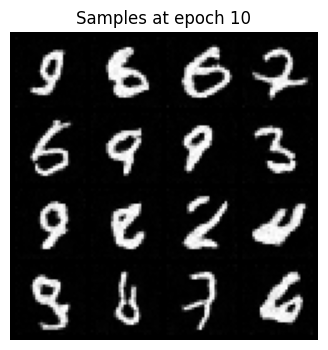

Total Epochs:  11%|█         | 11/100 [02:02<16:02, 10.81s/it]

Epoch 11 done. Avg Loss: 0.0542


Total Epochs:  12%|█▏        | 12/100 [02:14<16:17, 11.10s/it]

Epoch 12 done. Avg Loss: 0.0538


Total Epochs:  13%|█▎        | 13/100 [02:23<15:17, 10.55s/it]

Epoch 13 done. Avg Loss: 0.0523


Total Epochs:  14%|█▍        | 14/100 [02:34<15:20, 10.71s/it]

Epoch 14 done. Avg Loss: 0.0526


Total Epochs:  15%|█▌        | 15/100 [02:45<15:11, 10.72s/it]

Epoch 15 done. Avg Loss: 0.0508


Total Epochs:  16%|█▌        | 16/100 [02:56<15:10, 10.84s/it]

Epoch 16 done. Avg Loss: 0.0499


Total Epochs:  17%|█▋        | 17/100 [03:05<14:26, 10.44s/it]

Epoch 17 done. Avg Loss: 0.0496


Total Epochs:  18%|█▊        | 18/100 [03:17<14:36, 10.69s/it]

Epoch 18 done. Avg Loss: 0.0487


Total Epochs:  19%|█▉        | 19/100 [03:26<14:06, 10.45s/it]

Epoch 19 done. Avg Loss: 0.0491


Epoch 20 done. Avg Loss: 0.0478


Sampling: 100%|██████████| 200/200 [00:00<00:00, 436.08it/s]


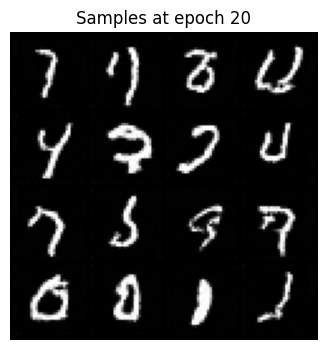

Total Epochs:  21%|██        | 21/100 [03:50<14:39, 11.13s/it]

Epoch 21 done. Avg Loss: 0.0477


Total Epochs:  22%|██▏       | 22/100 [04:02<14:42, 11.31s/it]

Epoch 22 done. Avg Loss: 0.0471


Total Epochs:  23%|██▎       | 23/100 [04:13<14:35, 11.38s/it]

Epoch 23 done. Avg Loss: 0.0470


Total Epochs:  24%|██▍       | 24/100 [04:26<14:53, 11.75s/it]

Epoch 24 done. Avg Loss: 0.0465


Total Epochs:  25%|██▌       | 25/100 [04:39<15:03, 12.05s/it]

Epoch 25 done. Avg Loss: 0.0461


Total Epochs:  26%|██▌       | 26/100 [04:48<13:44, 11.15s/it]

Epoch 26 done. Avg Loss: 0.0462


Total Epochs:  27%|██▋       | 27/100 [04:59<13:35, 11.17s/it]

Epoch 27 done. Avg Loss: 0.0453


Total Epochs:  28%|██▊       | 28/100 [05:10<13:12, 11.00s/it]

Epoch 28 done. Avg Loss: 0.0453


Total Epochs:  29%|██▉       | 29/100 [05:21<13:00, 11.00s/it]

Epoch 29 done. Avg Loss: 0.0449


Epoch 30 done. Avg Loss: 0.0452


Sampling: 100%|██████████| 200/200 [00:00<00:00, 697.62it/s]


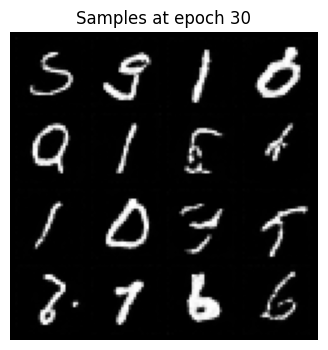

Total Epochs:  31%|███       | 31/100 [05:42<12:16, 10.68s/it]

Epoch 31 done. Avg Loss: 0.0444


Total Epochs:  32%|███▏      | 32/100 [05:53<12:20, 10.89s/it]

Epoch 32 done. Avg Loss: 0.0447


Total Epochs:  33%|███▎      | 33/100 [06:04<12:12, 10.93s/it]

Epoch 33 done. Avg Loss: 0.0437


Total Epochs:  34%|███▍      | 34/100 [06:16<12:17, 11.18s/it]

Epoch 34 done. Avg Loss: 0.0439


Total Epochs:  35%|███▌      | 35/100 [06:28<12:14, 11.30s/it]

Epoch 35 done. Avg Loss: 0.0440


Total Epochs:  36%|███▌      | 36/100 [06:39<12:08, 11.39s/it]

Epoch 36 done. Avg Loss: 0.0438


Total Epochs:  37%|███▋      | 37/100 [06:49<11:21, 10.82s/it]

Epoch 37 done. Avg Loss: 0.0436


Total Epochs:  38%|███▊      | 38/100 [06:59<11:04, 10.72s/it]

Epoch 38 done. Avg Loss: 0.0431


Total Epochs:  39%|███▉      | 39/100 [07:09<10:43, 10.55s/it]

Epoch 39 done. Avg Loss: 0.0430


Epoch 40 done. Avg Loss: 0.0433


Sampling: 100%|██████████| 200/200 [00:00<00:00, 386.82it/s]


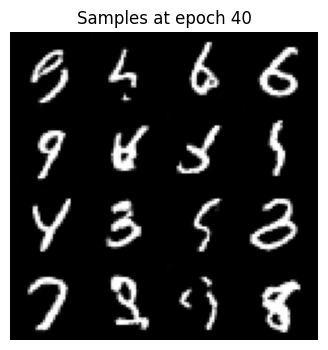

Total Epochs:  41%|████      | 41/100 [07:34<11:13, 11.42s/it]

Epoch 41 done. Avg Loss: 0.0430


Total Epochs:  42%|████▏     | 42/100 [07:46<11:08, 11.53s/it]

Epoch 42 done. Avg Loss: 0.0432


Total Epochs:  43%|████▎     | 43/100 [07:57<10:47, 11.35s/it]

Epoch 43 done. Avg Loss: 0.0425


Total Epochs:  44%|████▍     | 44/100 [08:08<10:37, 11.38s/it]

Epoch 44 done. Avg Loss: 0.0424


Total Epochs:  45%|████▌     | 45/100 [08:18<10:05, 11.00s/it]

Epoch 45 done. Avg Loss: 0.0425


Total Epochs:  46%|████▌     | 46/100 [08:31<10:32, 11.71s/it]

Epoch 46 done. Avg Loss: 0.0421


Total Epochs:  47%|████▋     | 47/100 [08:43<10:21, 11.73s/it]

Epoch 47 done. Avg Loss: 0.0425


Total Epochs:  48%|████▊     | 48/100 [08:59<11:05, 12.80s/it]

Epoch 48 done. Avg Loss: 0.0419


Total Epochs:  49%|████▉     | 49/100 [09:15<11:52, 13.96s/it]

Epoch 49 done. Avg Loss: 0.0417


Epoch 50 done. Avg Loss: 0.0420


Sampling: 100%|██████████| 200/200 [00:00<00:00, 278.07it/s]


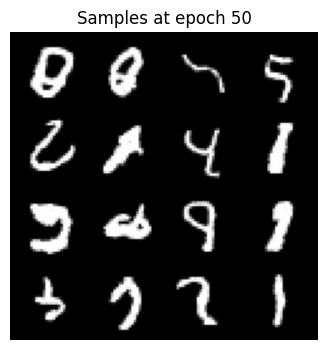

Total Epochs:  51%|█████     | 51/100 [09:49<12:35, 15.41s/it]

Epoch 51 done. Avg Loss: 0.0419


Total Epochs:  52%|█████▏    | 52/100 [10:06<12:38, 15.80s/it]

Epoch 52 done. Avg Loss: 0.0416


Total Epochs:  53%|█████▎    | 53/100 [10:23<12:37, 16.12s/it]

Epoch 53 done. Avg Loss: 0.0420


Total Epochs:  54%|█████▍    | 54/100 [10:40<12:38, 16.50s/it]

Epoch 54 done. Avg Loss: 0.0417


Total Epochs:  55%|█████▌    | 55/100 [10:58<12:35, 16.79s/it]

Epoch 55 done. Avg Loss: 0.0414


Total Epochs:  56%|█████▌    | 56/100 [11:15<12:24, 16.91s/it]

Epoch 56 done. Avg Loss: 0.0414


Total Epochs:  57%|█████▋    | 57/100 [11:31<11:58, 16.71s/it]

Epoch 57 done. Avg Loss: 0.0410


Total Epochs:  58%|█████▊    | 58/100 [11:48<11:45, 16.80s/it]

Epoch 58 done. Avg Loss: 0.0413


Total Epochs:  59%|█████▉    | 59/100 [12:04<11:23, 16.66s/it]

Epoch 59 done. Avg Loss: 0.0411


Epoch 60 done. Avg Loss: 0.0412


Sampling: 100%|██████████| 200/200 [00:00<00:00, 282.16it/s]


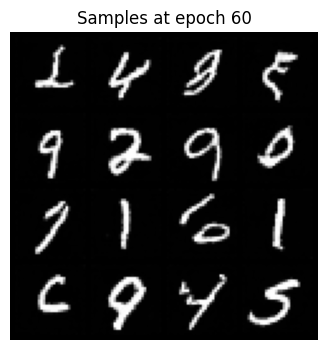

Total Epochs:  61%|██████    | 61/100 [12:39<11:04, 17.04s/it]

Epoch 61 done. Avg Loss: 0.0412


Total Epochs:  62%|██████▏   | 62/100 [12:56<10:48, 17.08s/it]

Epoch 62 done. Avg Loss: 0.0408


Total Epochs:  63%|██████▎   | 63/100 [13:14<10:34, 17.16s/it]

Epoch 63 done. Avg Loss: 0.0410


Total Epochs:  64%|██████▍   | 64/100 [13:30<10:07, 16.88s/it]

Epoch 64 done. Avg Loss: 0.0407


Total Epochs:  65%|██████▌   | 65/100 [13:45<09:36, 16.48s/it]

Epoch 65 done. Avg Loss: 0.0410


Total Epochs:  66%|██████▌   | 66/100 [14:02<09:26, 16.67s/it]

Epoch 66 done. Avg Loss: 0.0406


Total Epochs:  67%|██████▋   | 67/100 [14:19<09:07, 16.59s/it]

Epoch 67 done. Avg Loss: 0.0405


Total Epochs:  68%|██████▊   | 68/100 [14:36<08:58, 16.82s/it]

Epoch 68 done. Avg Loss: 0.0408


Total Epochs:  69%|██████▉   | 69/100 [14:52<08:33, 16.56s/it]

Epoch 69 done. Avg Loss: 0.0403


Epoch 70 done. Avg Loss: 0.0407


Sampling: 100%|██████████| 200/200 [00:00<00:00, 328.78it/s]


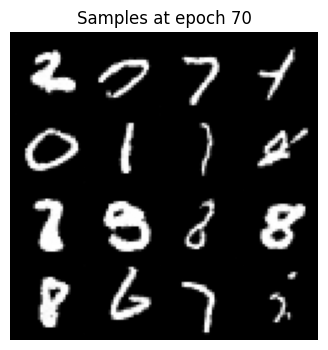

Total Epochs:  71%|███████   | 71/100 [15:27<08:09, 16.87s/it]

Epoch 71 done. Avg Loss: 0.0407


Total Epochs:  72%|███████▏  | 72/100 [15:43<07:48, 16.74s/it]

Epoch 72 done. Avg Loss: 0.0402


Total Epochs:  73%|███████▎  | 73/100 [16:00<07:31, 16.74s/it]

Epoch 73 done. Avg Loss: 0.0401


Total Epochs:  74%|███████▍  | 74/100 [16:16<07:12, 16.63s/it]

Epoch 74 done. Avg Loss: 0.0400


Total Epochs:  75%|███████▌  | 75/100 [16:33<06:57, 16.71s/it]

Epoch 75 done. Avg Loss: 0.0402


Total Epochs:  76%|███████▌  | 76/100 [16:50<06:44, 16.86s/it]

Epoch 76 done. Avg Loss: 0.0406


Total Epochs:  77%|███████▋  | 77/100 [17:06<06:23, 16.66s/it]

Epoch 77 done. Avg Loss: 0.0404


Total Epochs:  78%|███████▊  | 78/100 [17:23<06:06, 16.67s/it]

Epoch 78 done. Avg Loss: 0.0404


Total Epochs:  79%|███████▉  | 79/100 [17:41<05:57, 17.01s/it]

Epoch 79 done. Avg Loss: 0.0403


Epoch 80 done. Avg Loss: 0.0400


Sampling: 100%|██████████| 200/200 [00:00<00:00, 270.78it/s]


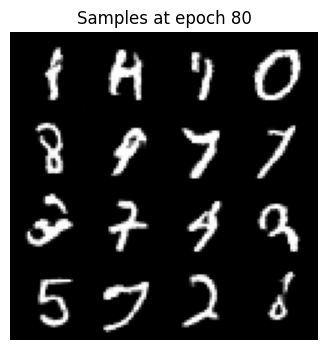

Total Epochs:  81%|████████  | 81/100 [18:15<05:25, 17.13s/it]

Epoch 81 done. Avg Loss: 0.0403


Total Epochs:  82%|████████▏ | 82/100 [18:32<05:04, 16.94s/it]

Epoch 82 done. Avg Loss: 0.0400


Total Epochs:  83%|████████▎ | 83/100 [18:49<04:48, 16.99s/it]

Epoch 83 done. Avg Loss: 0.0397


Total Epochs:  84%|████████▍ | 84/100 [19:05<04:27, 16.72s/it]

Epoch 84 done. Avg Loss: 0.0405


Total Epochs:  85%|████████▌ | 85/100 [19:21<04:09, 16.65s/it]

Epoch 85 done. Avg Loss: 0.0401


Total Epochs:  86%|████████▌ | 86/100 [19:40<03:59, 17.10s/it]

Epoch 86 done. Avg Loss: 0.0397


Total Epochs:  87%|████████▋ | 87/100 [19:57<03:44, 17.28s/it]

Epoch 87 done. Avg Loss: 0.0397


Total Epochs:  88%|████████▊ | 88/100 [20:15<03:28, 17.41s/it]

Epoch 88 done. Avg Loss: 0.0401


Total Epochs:  89%|████████▉ | 89/100 [20:33<03:12, 17.46s/it]

Epoch 89 done. Avg Loss: 0.0400


Epoch 90 done. Avg Loss: 0.0397


Sampling: 100%|██████████| 200/200 [00:00<00:00, 298.14it/s]


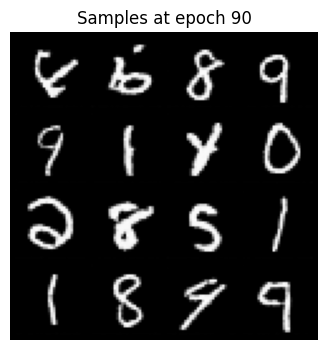

Total Epochs:  91%|█████████ | 91/100 [21:07<02:36, 17.38s/it]

Epoch 91 done. Avg Loss: 0.0398


Total Epochs:  92%|█████████▏| 92/100 [21:25<02:18, 17.29s/it]

Epoch 92 done. Avg Loss: 0.0397


Total Epochs:  93%|█████████▎| 93/100 [21:42<02:01, 17.38s/it]

Epoch 93 done. Avg Loss: 0.0402


Total Epochs:  94%|█████████▍| 94/100 [22:00<01:45, 17.52s/it]

Epoch 94 done. Avg Loss: 0.0394


Total Epochs:  95%|█████████▌| 95/100 [22:16<01:25, 17.12s/it]

Epoch 95 done. Avg Loss: 0.0397


Total Epochs:  96%|█████████▌| 96/100 [22:34<01:08, 17.23s/it]

Epoch 96 done. Avg Loss: 0.0393


Total Epochs:  97%|█████████▋| 97/100 [22:51<00:51, 17.29s/it]

Epoch 97 done. Avg Loss: 0.0397


Total Epochs:  98%|█████████▊| 98/100 [23:07<00:33, 16.88s/it]

Epoch 98 done. Avg Loss: 0.0395


Total Epochs:  99%|█████████▉| 99/100 [23:23<00:16, 16.63s/it]

Epoch 99 done. Avg Loss: 0.0390


Epoch 100 done. Avg Loss: 0.0397


Sampling: 100%|██████████| 200/200 [00:00<00:00, 295.29it/s]


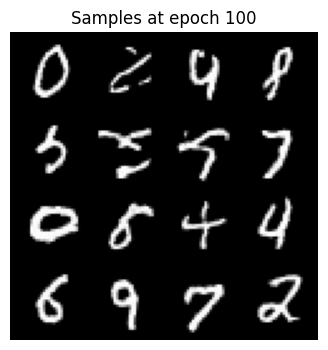

Total Epochs: 100%|██████████| 100/100 [23:39<00:00, 14.20s/it]

Training complete!


In [2]:
train_mnist_diffusion(
    lr=1e-3,
    batch_size=1024,  
    epochs=100,      
    timesteps=200,  
    model_base_dim=16, 
    dim_mults=[2, 4],  
    num_res_blocks_encoder=1, 
    num_res_blocks_decoder=1, 
    num_res_blocks_mid=1,     
    device="cuda" if torch.cuda.is_available() else "cpu",
    log_freq=100,     
    show_every=10,    
    n_samples=16,
)

UNet model has 1,730,881 trainable parameters.


Total Epochs:   1%|          | 1/100 [00:37<1:01:25, 37.22s/it]

Epoch 1 done. Avg Loss: 0.2504


Total Epochs:   2%|▏         | 2/100 [01:14<1:00:34, 37.09s/it]

Epoch 2 done. Avg Loss: 0.0908


Total Epochs:   3%|▎         | 3/100 [01:51<1:00:13, 37.25s/it]

Epoch 3 done. Avg Loss: 0.0735


Total Epochs:   4%|▍         | 4/100 [02:27<58:55, 36.83s/it]  

Epoch 4 done. Avg Loss: 0.0659


Total Epochs:   5%|▌         | 5/100 [03:04<58:26, 36.91s/it]

Epoch 5 done. Avg Loss: 0.0594


Total Epochs:   6%|▌         | 6/100 [03:42<57:59, 37.02s/it]

Epoch 6 done. Avg Loss: 0.0568


Total Epochs:   7%|▋         | 7/100 [04:18<57:17, 36.96s/it]

Epoch 7 done. Avg Loss: 0.0540


Total Epochs:   8%|▊         | 8/100 [04:56<57:04, 37.22s/it]

Epoch 8 done. Avg Loss: 0.0529


Total Epochs:   9%|▉         | 9/100 [05:34<56:50, 37.48s/it]

Epoch 9 done. Avg Loss: 0.0507


Epoch 10 done. Avg Loss: 0.0504


Sampling: 100%|██████████| 400/400 [00:01<00:00, 227.70it/s]


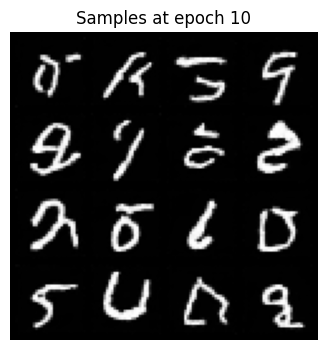

Total Epochs:  11%|█         | 11/100 [06:51<56:07, 37.83s/it]

Epoch 11 done. Avg Loss: 0.0488


Total Epochs:  12%|█▏        | 12/100 [07:29<55:33, 37.88s/it]

Epoch 12 done. Avg Loss: 0.0473


Total Epochs:  13%|█▎        | 13/100 [08:07<54:55, 37.88s/it]

Epoch 13 done. Avg Loss: 0.0470


Total Epochs:  14%|█▍        | 14/100 [08:44<54:09, 37.79s/it]

Epoch 14 done. Avg Loss: 0.0461


Total Epochs:  15%|█▌        | 15/100 [09:22<53:36, 37.84s/it]

Epoch 15 done. Avg Loss: 0.0451


Total Epochs:  16%|█▌        | 16/100 [10:00<53:04, 37.91s/it]

Epoch 16 done. Avg Loss: 0.0455


Total Epochs:  17%|█▋        | 17/100 [10:39<52:33, 38.00s/it]

Epoch 17 done. Avg Loss: 0.0439


Total Epochs:  18%|█▊        | 18/100 [11:17<51:56, 38.01s/it]

Epoch 18 done. Avg Loss: 0.0439


Total Epochs:  19%|█▉        | 19/100 [11:55<51:21, 38.04s/it]

Epoch 19 done. Avg Loss: 0.0435


Epoch 20 done. Avg Loss: 0.0441


Sampling: 100%|██████████| 400/400 [00:01<00:00, 257.33it/s]


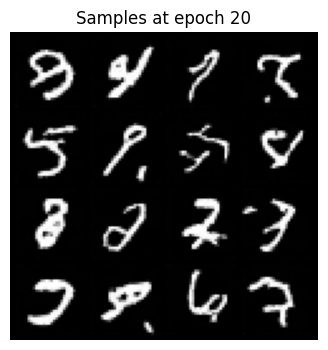

Total Epochs:  21%|██        | 21/100 [13:11<50:07, 38.07s/it]

Epoch 21 done. Avg Loss: 0.0436


Total Epochs:  22%|██▏       | 22/100 [13:49<49:18, 37.93s/it]

Epoch 22 done. Avg Loss: 0.0433


Total Epochs:  23%|██▎       | 23/100 [14:27<48:34, 37.85s/it]

Epoch 23 done. Avg Loss: 0.0429


Total Epochs:  24%|██▍       | 24/100 [15:04<47:51, 37.79s/it]

Epoch 24 done. Avg Loss: 0.0423


Total Epochs:  25%|██▌       | 25/100 [15:42<47:03, 37.65s/it]

Epoch 25 done. Avg Loss: 0.0418


Total Epochs:  26%|██▌       | 26/100 [16:20<46:34, 37.76s/it]

Epoch 26 done. Avg Loss: 0.0419


Total Epochs:  27%|██▋       | 27/100 [16:57<45:48, 37.66s/it]

Epoch 27 done. Avg Loss: 0.0420


Total Epochs:  28%|██▊       | 28/100 [17:34<44:54, 37.42s/it]

Epoch 28 done. Avg Loss: 0.0417


Total Epochs:  29%|██▉       | 29/100 [18:12<44:37, 37.71s/it]

Epoch 29 done. Avg Loss: 0.0412


Epoch 30 done. Avg Loss: 0.0408


Sampling: 100%|██████████| 400/400 [00:01<00:00, 229.83it/s]


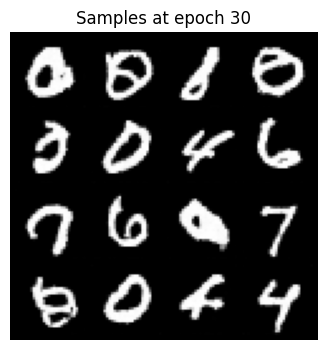

Total Epochs:  31%|███       | 31/100 [19:29<43:37, 37.94s/it]

Epoch 31 done. Avg Loss: 0.0409


Total Epochs:  32%|███▏      | 32/100 [20:07<42:56, 37.88s/it]

Epoch 32 done. Avg Loss: 0.0408


Total Epochs:  33%|███▎      | 33/100 [20:45<42:21, 37.94s/it]

Epoch 33 done. Avg Loss: 0.0408


Total Epochs:  34%|███▍      | 34/100 [21:23<41:44, 37.94s/it]

Epoch 34 done. Avg Loss: 0.0405


Total Epochs:  35%|███▌      | 35/100 [22:01<41:09, 37.99s/it]

Epoch 35 done. Avg Loss: 0.0407


Total Epochs:  36%|███▌      | 36/100 [22:37<40:07, 37.61s/it]

Epoch 36 done. Avg Loss: 0.0398


Total Epochs:  37%|███▋      | 37/100 [23:15<39:27, 37.57s/it]

Epoch 37 done. Avg Loss: 0.0402


Total Epochs:  38%|███▊      | 38/100 [23:53<38:53, 37.64s/it]

Epoch 38 done. Avg Loss: 0.0404


Total Epochs:  39%|███▉      | 39/100 [24:31<38:23, 37.76s/it]

Epoch 39 done. Avg Loss: 0.0398


Epoch 40 done. Avg Loss: 0.0403


Sampling: 100%|██████████| 400/400 [00:01<00:00, 223.69it/s]


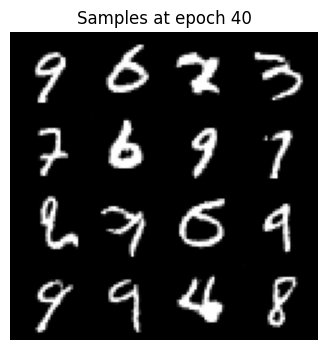

Total Epochs:  41%|████      | 41/100 [25:48<37:26, 38.08s/it]

Epoch 41 done. Avg Loss: 0.0396


Total Epochs:  42%|████▏     | 42/100 [26:26<36:52, 38.15s/it]

Epoch 42 done. Avg Loss: 0.0398


Total Epochs:  43%|████▎     | 43/100 [27:04<36:15, 38.17s/it]

Epoch 43 done. Avg Loss: 0.0397


Total Epochs:  44%|████▍     | 44/100 [27:42<35:30, 38.05s/it]

Epoch 44 done. Avg Loss: 0.0393


Total Epochs:  45%|████▌     | 45/100 [28:20<34:49, 38.00s/it]

Epoch 45 done. Avg Loss: 0.0392


Total Epochs:  46%|████▌     | 46/100 [28:57<34:01, 37.80s/it]

Epoch 46 done. Avg Loss: 0.0391


Total Epochs:  47%|████▋     | 47/100 [29:35<33:26, 37.86s/it]

Epoch 47 done. Avg Loss: 0.0392


Total Epochs:  48%|████▊     | 48/100 [30:13<32:43, 37.75s/it]

Epoch 48 done. Avg Loss: 0.0387


Total Epochs:  49%|████▉     | 49/100 [30:50<32:00, 37.66s/it]

Epoch 49 done. Avg Loss: 0.0390


Epoch 50 done. Avg Loss: 0.0389


Sampling: 100%|██████████| 400/400 [00:01<00:00, 227.76it/s]


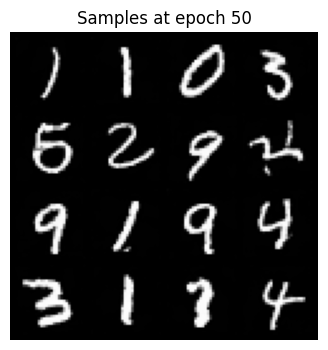

Total Epochs:  51%|█████     | 51/100 [32:07<31:04, 38.05s/it]

Epoch 51 done. Avg Loss: 0.0388


Total Epochs:  52%|█████▏    | 52/100 [32:45<30:16, 37.85s/it]

Epoch 52 done. Avg Loss: 0.0389


Total Epochs:  53%|█████▎    | 53/100 [33:22<29:26, 37.59s/it]

Epoch 53 done. Avg Loss: 0.0388


Total Epochs:  54%|█████▍    | 54/100 [33:59<28:42, 37.44s/it]

Epoch 54 done. Avg Loss: 0.0384


Total Epochs:  55%|█████▌    | 55/100 [34:36<27:57, 37.27s/it]

Epoch 55 done. Avg Loss: 0.0387


Total Epochs:  56%|█████▌    | 56/100 [35:13<27:17, 37.21s/it]

Epoch 56 done. Avg Loss: 0.0385


Total Epochs:  57%|█████▋    | 57/100 [35:49<26:31, 37.01s/it]

Epoch 57 done. Avg Loss: 0.0388


Total Epochs:  58%|█████▊    | 58/100 [36:26<25:46, 36.81s/it]

Epoch 58 done. Avg Loss: 0.0384


Total Epochs:  59%|█████▉    | 59/100 [37:03<25:18, 37.04s/it]

Epoch 59 done. Avg Loss: 0.0385


Epoch 60 done. Avg Loss: 0.0382


Sampling: 100%|██████████| 400/400 [00:01<00:00, 229.81it/s]


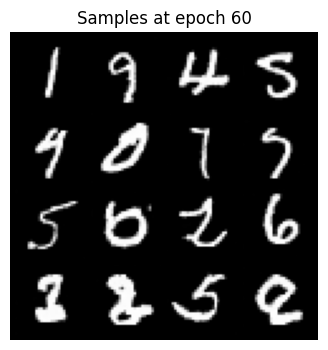

Total Epochs:  61%|██████    | 61/100 [38:20<24:30, 37.70s/it]

Epoch 61 done. Avg Loss: 0.0385


Total Epochs:  62%|██████▏   | 62/100 [38:57<23:35, 37.25s/it]

Epoch 62 done. Avg Loss: 0.0382


Total Epochs:  63%|██████▎   | 63/100 [39:15<19:31, 31.67s/it]

Epoch 63 done. Avg Loss: 0.0384


Total Epochs:  64%|██████▍   | 64/100 [39:33<16:31, 27.53s/it]

Epoch 64 done. Avg Loss: 0.0379


Total Epochs:  65%|██████▌   | 65/100 [39:51<14:25, 24.72s/it]

Epoch 65 done. Avg Loss: 0.0383


Total Epochs:  66%|██████▌   | 66/100 [40:11<13:12, 23.31s/it]

Epoch 66 done. Avg Loss: 0.0379


Total Epochs:  67%|██████▋   | 67/100 [40:30<12:01, 21.87s/it]

Epoch 67 done. Avg Loss: 0.0378


Total Epochs:  68%|██████▊   | 68/100 [40:48<10:59, 20.61s/it]

Epoch 68 done. Avg Loss: 0.0378


Total Epochs:  69%|██████▉   | 69/100 [41:07<10:26, 20.22s/it]

Epoch 69 done. Avg Loss: 0.0379


Epoch 70 done. Avg Loss: 0.0379


Sampling: 100%|██████████| 400/400 [00:01<00:00, 337.68it/s]


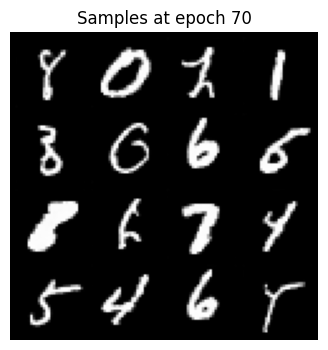

Total Epochs:  71%|███████   | 71/100 [41:46<09:35, 19.84s/it]

Epoch 71 done. Avg Loss: 0.0379


Total Epochs:  72%|███████▏  | 72/100 [42:05<09:11, 19.70s/it]

Epoch 72 done. Avg Loss: 0.0380


Total Epochs:  73%|███████▎  | 73/100 [42:25<08:53, 19.78s/it]

Epoch 73 done. Avg Loss: 0.0377


Total Epochs:  74%|███████▍  | 74/100 [42:43<08:21, 19.30s/it]

Epoch 74 done. Avg Loss: 0.0377


Total Epochs:  75%|███████▌  | 75/100 [43:02<07:58, 19.15s/it]

Epoch 75 done. Avg Loss: 0.0377


Total Epochs:  76%|███████▌  | 76/100 [43:21<07:33, 18.90s/it]

Epoch 76 done. Avg Loss: 0.0377


Total Epochs:  77%|███████▋  | 77/100 [43:40<07:19, 19.10s/it]

Epoch 77 done. Avg Loss: 0.0377


Total Epochs:  78%|███████▊  | 78/100 [44:00<07:05, 19.34s/it]

Epoch 78 done. Avg Loss: 0.0380


Total Epochs:  79%|███████▉  | 79/100 [44:20<06:50, 19.55s/it]

Epoch 79 done. Avg Loss: 0.0374


Epoch 80 done. Avg Loss: 0.0375


Sampling: 100%|██████████| 400/400 [00:01<00:00, 337.93it/s]


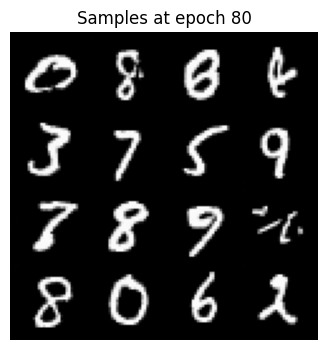

Total Epochs:  81%|████████  | 81/100 [45:01<06:19, 19.99s/it]

Epoch 81 done. Avg Loss: 0.0375


Total Epochs:  82%|████████▏ | 82/100 [45:20<05:53, 19.61s/it]

Epoch 82 done. Avg Loss: 0.0376


Total Epochs:  83%|████████▎ | 83/100 [45:37<05:22, 18.99s/it]

Epoch 83 done. Avg Loss: 0.0376


Total Epochs:  84%|████████▍ | 84/100 [45:56<05:02, 18.88s/it]

Epoch 84 done. Avg Loss: 0.0375


Total Epochs:  85%|████████▌ | 85/100 [46:14<04:40, 18.73s/it]

Epoch 85 done. Avg Loss: 0.0371


Total Epochs:  86%|████████▌ | 86/100 [46:32<04:19, 18.52s/it]

Epoch 86 done. Avg Loss: 0.0372


Total Epochs:  87%|████████▋ | 87/100 [46:50<03:57, 18.26s/it]

Epoch 87 done. Avg Loss: 0.0375


Total Epochs:  88%|████████▊ | 88/100 [47:10<03:44, 18.69s/it]

Epoch 88 done. Avg Loss: 0.0375


Total Epochs:  89%|████████▉ | 89/100 [47:29<03:26, 18.78s/it]

Epoch 89 done. Avg Loss: 0.0374


Epoch 90 done. Avg Loss: 0.0370


Sampling: 100%|██████████| 400/400 [00:01<00:00, 338.48it/s]


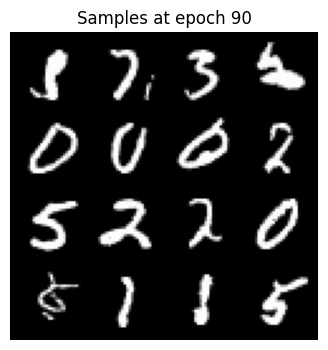

Total Epochs:  91%|█████████ | 91/100 [48:09<02:52, 19.21s/it]

Epoch 91 done. Avg Loss: 0.0373


Total Epochs:  92%|█████████▏| 92/100 [48:27<02:32, 19.05s/it]

Epoch 92 done. Avg Loss: 0.0369


Total Epochs:  93%|█████████▎| 93/100 [48:46<02:12, 18.90s/it]

Epoch 93 done. Avg Loss: 0.0373


Total Epochs:  94%|█████████▍| 94/100 [49:05<01:54, 19.02s/it]

Epoch 94 done. Avg Loss: 0.0374


Total Epochs:  95%|█████████▌| 95/100 [49:23<01:32, 18.59s/it]

Epoch 95 done. Avg Loss: 0.0371


Total Epochs:  96%|█████████▌| 96/100 [49:41<01:14, 18.55s/it]

Epoch 96 done. Avg Loss: 0.0372


Total Epochs:  97%|█████████▋| 97/100 [50:00<00:56, 18.71s/it]

Epoch 97 done. Avg Loss: 0.0373


Total Epochs:  98%|█████████▊| 98/100 [50:19<00:37, 18.68s/it]

Epoch 98 done. Avg Loss: 0.0372


Total Epochs:  99%|█████████▉| 99/100 [50:37<00:18, 18.57s/it]

Epoch 99 done. Avg Loss: 0.0370


Epoch 100 done. Avg Loss: 0.0369


Sampling: 100%|██████████| 400/400 [00:00<00:00, 448.89it/s]


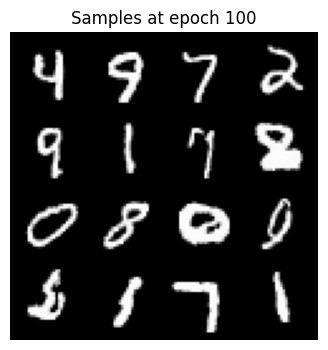

Total Epochs: 100%|██████████| 100/100 [50:56<00:00, 30.56s/it]

Training complete!


In [3]:
train_mnist_diffusion(
    lr=1e-3,
    batch_size=1024,  
    epochs=100,      
    timesteps=400,   
    model_base_dim=32, 
    dim_mults=[2, 4],  
    num_res_blocks_encoder=2, 
    num_res_blocks_decoder=2, 
    num_res_blocks_mid=1,     
    device="cuda" if torch.cuda.is_available() else "cpu",
    log_freq=100,     
    show_every=10,    
    n_samples=16,
)

UNet model has 1,833,281 trainable parameters.


Total Epochs:   1%|          | 1/100 [00:19<32:47, 19.87s/it]

Epoch 1 done. Avg Loss: 0.2257


Total Epochs:   2%|▏         | 2/100 [00:39<32:41, 20.01s/it]

Epoch 2 done. Avg Loss: 0.0905


Total Epochs:   3%|▎         | 3/100 [01:00<32:46, 20.28s/it]

Epoch 3 done. Avg Loss: 0.0745


Total Epochs:   4%|▍         | 4/100 [01:19<31:29, 19.68s/it]

Epoch 4 done. Avg Loss: 0.0662


Total Epochs:   5%|▌         | 5/100 [01:38<30:50, 19.47s/it]

Epoch 5 done. Avg Loss: 0.0601


Total Epochs:   6%|▌         | 6/100 [01:58<30:33, 19.50s/it]

Epoch 6 done. Avg Loss: 0.0574


Total Epochs:   7%|▋         | 7/100 [02:19<31:07, 20.09s/it]

Epoch 7 done. Avg Loss: 0.0554


Total Epochs:   8%|▊         | 8/100 [02:38<30:32, 19.91s/it]

Epoch 8 done. Avg Loss: 0.0529


Total Epochs:   9%|▉         | 9/100 [02:59<30:45, 20.28s/it]

Epoch 9 done. Avg Loss: 0.0509


Epoch 10 done. Avg Loss: 0.0500


Sampling: 100%|██████████| 800/800 [00:02<00:00, 329.44it/s]


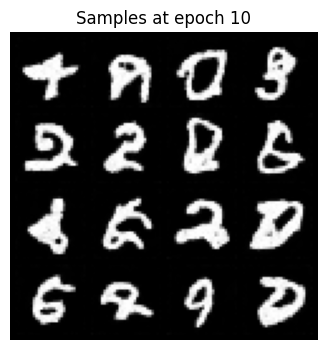

Total Epochs:  11%|█         | 11/100 [03:43<30:54, 20.84s/it]

Epoch 11 done. Avg Loss: 0.0485


Total Epochs:  12%|█▏        | 12/100 [04:03<30:33, 20.84s/it]

Epoch 12 done. Avg Loss: 0.0478


Total Epochs:  13%|█▎        | 13/100 [04:23<29:28, 20.33s/it]

Epoch 13 done. Avg Loss: 0.0474


Total Epochs:  14%|█▍        | 14/100 [04:42<28:58, 20.21s/it]

Epoch 14 done. Avg Loss: 0.0465


Total Epochs:  15%|█▌        | 15/100 [05:02<28:25, 20.07s/it]

Epoch 15 done. Avg Loss: 0.0456


Total Epochs:  16%|█▌        | 16/100 [05:23<28:20, 20.24s/it]

Epoch 16 done. Avg Loss: 0.0451


Total Epochs:  17%|█▋        | 17/100 [05:44<28:12, 20.40s/it]

Epoch 17 done. Avg Loss: 0.0446


Total Epochs:  18%|█▊        | 18/100 [06:05<28:08, 20.59s/it]

Epoch 18 done. Avg Loss: 0.0442


Total Epochs:  19%|█▉        | 19/100 [06:26<28:01, 20.75s/it]

Epoch 19 done. Avg Loss: 0.0440


Epoch 20 done. Avg Loss: 0.0436


Sampling: 100%|██████████| 800/800 [00:01<00:00, 432.21it/s]


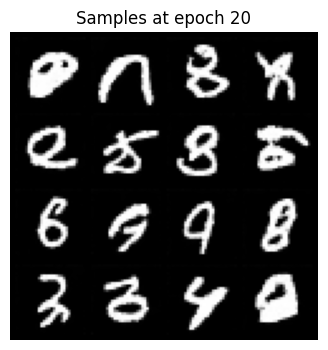

Total Epochs:  21%|██        | 21/100 [07:09<27:56, 21.23s/it]

Epoch 21 done. Avg Loss: 0.0429


Total Epochs:  22%|██▏       | 22/100 [07:30<27:27, 21.12s/it]

Epoch 22 done. Avg Loss: 0.0428


Total Epochs:  23%|██▎       | 23/100 [07:51<27:00, 21.04s/it]

Epoch 23 done. Avg Loss: 0.0424


Total Epochs:  24%|██▍       | 24/100 [08:12<26:33, 20.97s/it]

Epoch 24 done. Avg Loss: 0.0425


Total Epochs:  25%|██▌       | 25/100 [08:31<25:29, 20.39s/it]

Epoch 25 done. Avg Loss: 0.0421


Total Epochs:  26%|██▌       | 26/100 [08:52<25:25, 20.62s/it]

Epoch 26 done. Avg Loss: 0.0417


Total Epochs:  27%|██▋       | 27/100 [09:13<25:14, 20.74s/it]

Epoch 27 done. Avg Loss: 0.0417


Total Epochs:  28%|██▊       | 28/100 [09:33<24:42, 20.59s/it]

Epoch 28 done. Avg Loss: 0.0412


Total Epochs:  29%|██▉       | 29/100 [09:53<24:00, 20.29s/it]

Epoch 29 done. Avg Loss: 0.0416


Epoch 30 done. Avg Loss: 0.0413


Sampling: 100%|██████████| 800/800 [00:02<00:00, 362.54it/s]


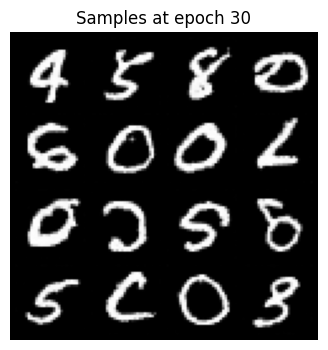

Total Epochs:  31%|███       | 31/100 [10:35<23:37, 20.55s/it]

Epoch 31 done. Avg Loss: 0.0408


Total Epochs:  32%|███▏      | 32/100 [10:54<22:43, 20.05s/it]

Epoch 32 done. Avg Loss: 0.0405


Total Epochs:  33%|███▎      | 33/100 [11:13<22:02, 19.73s/it]

Epoch 33 done. Avg Loss: 0.0406


Total Epochs:  34%|███▍      | 34/100 [11:31<21:23, 19.45s/it]

Epoch 34 done. Avg Loss: 0.0406


Total Epochs:  35%|███▌      | 35/100 [11:50<20:49, 19.22s/it]

Epoch 35 done. Avg Loss: 0.0397


Total Epochs:  36%|███▌      | 36/100 [12:10<20:41, 19.39s/it]

Epoch 36 done. Avg Loss: 0.0401


Total Epochs:  37%|███▋      | 37/100 [12:30<20:28, 19.49s/it]

Epoch 37 done. Avg Loss: 0.0401


Total Epochs:  38%|███▊      | 38/100 [12:51<20:38, 19.98s/it]

Epoch 38 done. Avg Loss: 0.0399


Total Epochs:  39%|███▉      | 39/100 [13:12<20:39, 20.33s/it]

Epoch 39 done. Avg Loss: 0.0398


Epoch 40 done. Avg Loss: 0.0401


Sampling: 100%|██████████| 800/800 [00:02<00:00, 332.96it/s]


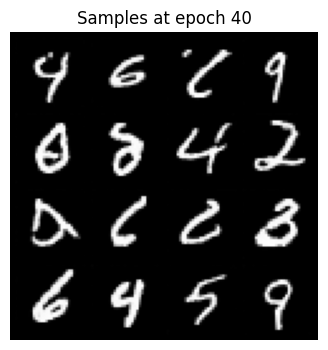

Total Epochs:  41%|████      | 41/100 [13:55<20:30, 20.86s/it]

Epoch 41 done. Avg Loss: 0.0397


Total Epochs:  42%|████▏     | 42/100 [14:15<20:01, 20.71s/it]

Epoch 42 done. Avg Loss: 0.0394


Total Epochs:  43%|████▎     | 43/100 [14:35<19:16, 20.30s/it]

Epoch 43 done. Avg Loss: 0.0397


Total Epochs:  44%|████▍     | 44/100 [14:56<19:08, 20.52s/it]

Epoch 44 done. Avg Loss: 0.0393


Total Epochs:  45%|████▌     | 45/100 [15:16<18:48, 20.52s/it]

Epoch 45 done. Avg Loss: 0.0394


Total Epochs:  46%|████▌     | 46/100 [15:37<18:29, 20.55s/it]

Epoch 46 done. Avg Loss: 0.0395


Total Epochs:  47%|████▋     | 47/100 [15:57<18:10, 20.57s/it]

Epoch 47 done. Avg Loss: 0.0389


Total Epochs:  48%|████▊     | 48/100 [16:19<17:59, 20.76s/it]

Epoch 48 done. Avg Loss: 0.0394


Total Epochs:  49%|████▉     | 49/100 [16:39<17:38, 20.75s/it]

Epoch 49 done. Avg Loss: 0.0387


Epoch 50 done. Avg Loss: 0.0388


Sampling: 100%|██████████| 800/800 [00:02<00:00, 389.14it/s]


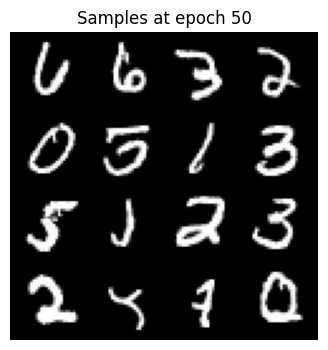

Total Epochs:  51%|█████     | 51/100 [17:21<16:52, 20.67s/it]

Epoch 51 done. Avg Loss: 0.0387


Total Epochs:  52%|█████▏    | 52/100 [17:40<16:09, 20.19s/it]

Epoch 52 done. Avg Loss: 0.0391


Total Epochs:  53%|█████▎    | 53/100 [18:01<15:49, 20.21s/it]

Epoch 53 done. Avg Loss: 0.0388


Total Epochs:  54%|█████▍    | 54/100 [18:22<15:49, 20.65s/it]

Epoch 54 done. Avg Loss: 0.0387


Total Epochs:  55%|█████▌    | 55/100 [18:44<15:41, 20.93s/it]

Epoch 55 done. Avg Loss: 0.0384


Total Epochs:  56%|█████▌    | 56/100 [19:06<15:42, 21.43s/it]

Epoch 56 done. Avg Loss: 0.0382


Total Epochs:  57%|█████▋    | 57/100 [19:27<15:12, 21.23s/it]

Epoch 57 done. Avg Loss: 0.0386


Total Epochs:  58%|█████▊    | 58/100 [19:48<14:50, 21.19s/it]

Epoch 58 done. Avg Loss: 0.0388


Total Epochs:  59%|█████▉    | 59/100 [20:09<14:21, 21.01s/it]

Epoch 59 done. Avg Loss: 0.0386


Epoch 60 done. Avg Loss: 0.0382


Sampling: 100%|██████████| 800/800 [00:02<00:00, 385.50it/s]


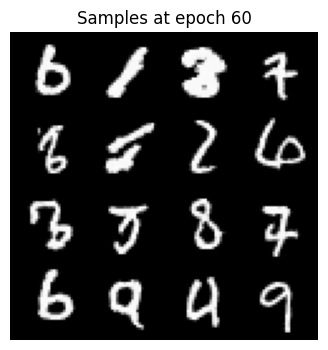

Total Epochs:  61%|██████    | 61/100 [20:51<13:36, 20.95s/it]

Epoch 61 done. Avg Loss: 0.0387


Total Epochs:  62%|██████▏   | 62/100 [21:11<13:05, 20.67s/it]

Epoch 62 done. Avg Loss: 0.0386


Total Epochs:  63%|██████▎   | 63/100 [21:32<12:47, 20.74s/it]

Epoch 63 done. Avg Loss: 0.0387


Total Epochs:  64%|██████▍   | 64/100 [21:52<12:17, 20.50s/it]

Epoch 64 done. Avg Loss: 0.0382


Total Epochs:  65%|██████▌   | 65/100 [22:12<11:55, 20.44s/it]

Epoch 65 done. Avg Loss: 0.0379


Total Epochs:  66%|██████▌   | 66/100 [22:34<11:50, 20.89s/it]

Epoch 66 done. Avg Loss: 0.0382


Total Epochs:  67%|██████▋   | 67/100 [22:56<11:42, 21.28s/it]

Epoch 67 done. Avg Loss: 0.0386


Total Epochs:  68%|██████▊   | 68/100 [23:19<11:30, 21.56s/it]

Epoch 68 done. Avg Loss: 0.0381


Total Epochs:  69%|██████▉   | 69/100 [23:39<11:02, 21.39s/it]

Epoch 69 done. Avg Loss: 0.0382


Epoch 70 done. Avg Loss: 0.0382


Sampling: 100%|██████████| 800/800 [00:02<00:00, 325.56it/s]


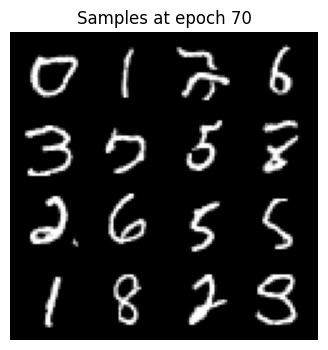

Total Epochs:  71%|███████   | 71/100 [24:24<10:32, 21.79s/it]

Epoch 71 done. Avg Loss: 0.0377


Total Epochs:  72%|███████▏  | 72/100 [24:45<10:03, 21.57s/it]

Epoch 72 done. Avg Loss: 0.0380


Total Epochs:  73%|███████▎  | 73/100 [25:07<09:42, 21.57s/it]

Epoch 73 done. Avg Loss: 0.0379


Total Epochs:  74%|███████▍  | 74/100 [25:28<09:20, 21.55s/it]

Epoch 74 done. Avg Loss: 0.0376


Total Epochs:  75%|███████▌  | 75/100 [25:49<08:57, 21.50s/it]

Epoch 75 done. Avg Loss: 0.0378


Total Epochs:  76%|███████▌  | 76/100 [26:10<08:31, 21.30s/it]

Epoch 76 done. Avg Loss: 0.0377


Total Epochs:  77%|███████▋  | 77/100 [26:30<08:00, 20.87s/it]

Epoch 77 done. Avg Loss: 0.0378


Total Epochs:  78%|███████▊  | 78/100 [26:50<07:35, 20.70s/it]

Epoch 78 done. Avg Loss: 0.0374


Total Epochs:  79%|███████▉  | 79/100 [27:11<07:14, 20.69s/it]

Epoch 79 done. Avg Loss: 0.0377


Epoch 80 done. Avg Loss: 0.0377


Sampling: 100%|██████████| 800/800 [00:01<00:00, 404.51it/s]


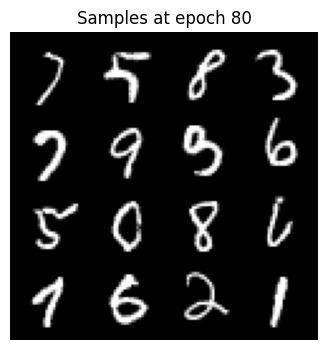

Total Epochs:  81%|████████  | 81/100 [27:55<06:42, 21.17s/it]

Epoch 81 done. Avg Loss: 0.0377


Total Epochs:  82%|████████▏ | 82/100 [28:15<06:18, 21.02s/it]

Epoch 82 done. Avg Loss: 0.0378


Total Epochs:  83%|████████▎ | 83/100 [28:36<05:53, 20.78s/it]

Epoch 83 done. Avg Loss: 0.0373


Total Epochs:  84%|████████▍ | 84/100 [28:56<05:28, 20.55s/it]

Epoch 84 done. Avg Loss: 0.0376


Total Epochs:  85%|████████▌ | 85/100 [29:17<05:13, 20.91s/it]

Epoch 85 done. Avg Loss: 0.0377


Total Epochs:  86%|████████▌ | 86/100 [29:39<04:55, 21.11s/it]

Epoch 86 done. Avg Loss: 0.0378


Total Epochs:  87%|████████▋ | 87/100 [29:59<04:31, 20.89s/it]

Epoch 87 done. Avg Loss: 0.0374


Total Epochs:  88%|████████▊ | 88/100 [30:20<04:08, 20.70s/it]

Epoch 88 done. Avg Loss: 0.0374


Total Epochs:  89%|████████▉ | 89/100 [30:41<03:49, 20.89s/it]

Epoch 89 done. Avg Loss: 0.0375


Epoch 90 done. Avg Loss: 0.0373


Sampling: 100%|██████████| 800/800 [00:01<00:00, 419.83it/s]


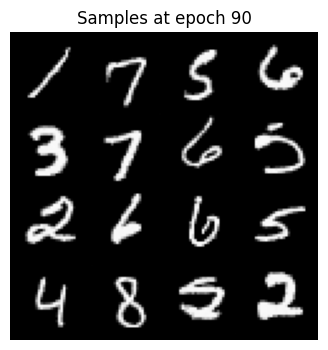

Total Epochs:  91%|█████████ | 91/100 [31:25<03:14, 21.58s/it]

Epoch 91 done. Avg Loss: 0.0376


Total Epochs:  92%|█████████▏| 92/100 [31:46<02:49, 21.22s/it]

Epoch 92 done. Avg Loss: 0.0374


Total Epochs:  93%|█████████▎| 93/100 [32:07<02:28, 21.22s/it]

Epoch 93 done. Avg Loss: 0.0373


Total Epochs:  94%|█████████▍| 94/100 [32:27<02:05, 20.85s/it]

Epoch 94 done. Avg Loss: 0.0372


Total Epochs:  95%|█████████▌| 95/100 [32:47<01:43, 20.64s/it]

Epoch 95 done. Avg Loss: 0.0372


Total Epochs:  96%|█████████▌| 96/100 [33:06<01:20, 20.15s/it]

Epoch 96 done. Avg Loss: 0.0373


Total Epochs:  97%|█████████▋| 97/100 [33:25<00:59, 19.88s/it]

Epoch 97 done. Avg Loss: 0.0373


Total Epochs:  98%|█████████▊| 98/100 [33:46<00:40, 20.20s/it]

Epoch 98 done. Avg Loss: 0.0373


Total Epochs:  99%|█████████▉| 99/100 [34:07<00:20, 20.24s/it]

Epoch 99 done. Avg Loss: 0.0370


Epoch 100 done. Avg Loss: 0.0370


Sampling: 100%|██████████| 800/800 [00:02<00:00, 335.63it/s]


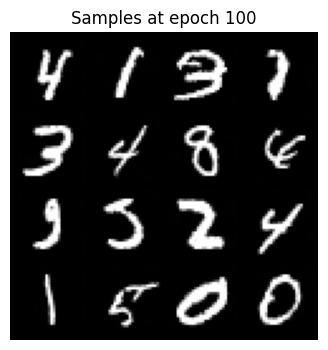

Total Epochs: 100%|██████████| 100/100 [34:30<00:00, 20.70s/it]

Training complete!


In [4]:
train_mnist_diffusion(
    lr=1e-3,
    batch_size=1024,  
    epochs=100,      
    timesteps=800,   
    model_base_dim=32, 
    dim_mults=[2, 4],  
    num_res_blocks_encoder=2, 
    num_res_blocks_decoder=2, 
    num_res_blocks_mid=1,     
    device="cuda" if torch.cuda.is_available() else "cpu",
    log_freq=100,     
    show_every=10,    
    n_samples=16,
)

The generated images are sharper than those of VAEs! But diffusion takes significantly more time than VAEs since it has to make way more forward passes, but more forward passes, the better the generated image quality is.